<h3 style="text-align: center;"><b>Классификация изображений</b></h3>
<h3 style="text-align: center;"><b>с применением сверточных нейронных сетей</b></h3>


## Приключение?

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)

### Установка зависимостей

In [356]:
import timm
from timm.loss import SoftTargetCrossEntropy

import os
import logging
import copy
from pathlib import Path

from tqdm import tqdm, tqdm_notebook

import pickle
from multiprocessing.pool import ThreadPool

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms
from torchvision.transforms import v2

from skimage import io
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import random
from PIL import Image
import pandas as pd
import numpy as np
from matplotlib import colors, pyplot as plt

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [357]:
import pkg_resources

for b in ['torch', 'torchvision', 'tqdm', 'matplotlib', 'seaborn', 'Pillow']:
    print(b + ' version: '+ pkg_resources.get_distribution(b).version)

torch version: 2.7.1
torchvision version: 0.22.1
tqdm version: 4.67.1
matplotlib version: 3.10.3
seaborn version: 0.13.2
Pillow version: 11.1.0


In [358]:
!python --version

Python 3.13.2


In [359]:
# Зафиксируем сиды для воспроизводимости
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.backends.cudnn.benchmark = True

In [360]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


### Работа с датасетом

In [361]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, label_encoder):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        # энкодер
        self.label_encoder = label_encoder

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        if self.mode != 'test':
            raw_labels = [path.parent.name for path in self.files]
            self.labels = self.label_encoder.transform(raw_labels)

        self.transform_train = transforms.Compose([
            transforms.RandomResizedCrop(RESCALE_SIZE, scale=(0.8, 1.0), ratio=(3/4, 4/3)),
            transforms.RandomHorizontalFlip(),

            transforms.RandAugment(num_ops=2, magnitude=9),
            # transforms.TrivialAugmentWide(),

            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

            # transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
            
            # # transforms.RandomEqualize(p=0.5),  # extreme
            # # transforms.RandomPosterize(bits=2, p=0.5),  # extreme
            # # transforms.RandomGrayscale(p=0.2),  # extreme
            # transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
            # transforms.RandomPerspective(distortion_scale=0.4, p=0.5),  # resize to make it fill
            # transforms.RandomHorizontalFlip(),
            # transforms.RandomRotation(15),
            # transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),  # extreme with hue

            # transforms.ToTensor(),
            # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        self.transform_val = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(RESCALE_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        x = self.load_sample(self.files[index])

        match self.mode:
            case 'train':
                x = self.transform_train(x)
                y = self.labels[index]
                return x, y
            case 'val':
                x = self.transform_val(x)
                y = self.labels[index]
                return x, y    
            case 'test':
                x = self.transform_val(x)
                return x


In [363]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
# определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./content/journey-springfield/train/')
TEST_DIR  = Path('./content/journey-springfield/testset/')

In [365]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files      = sorted(list(TEST_DIR.rglob('*.jpg')))

In [366]:
train_val_labels = [path.parent.name for path in train_val_files]

label_encoder = LabelEncoder()
label_encoder.fit(train_val_labels)

with open('label_encoder.pkl', 'wb') as le_dump_file:
    pickle.dump(label_encoder, le_dump_file)

train_files, val_files = train_test_split(train_val_files, 
                                          test_size=0.25,
                                          stratify=train_val_labels)

In [367]:
train_dataset = SimpsonsDataset(train_files, mode='train', label_encoder=label_encoder)
val_dataset   = SimpsonsDataset(val_files,   mode='val', label_encoder=label_encoder)
# test_dataset  = SimpsonsDataset(test_files,  mode='test')

In [368]:
batch_size = 32
num_workers = os.cpu_count()

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=num_workers)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [369]:
N_CLASSES = len(np.unique(train_val_labels))

Посмотрим на наши данные

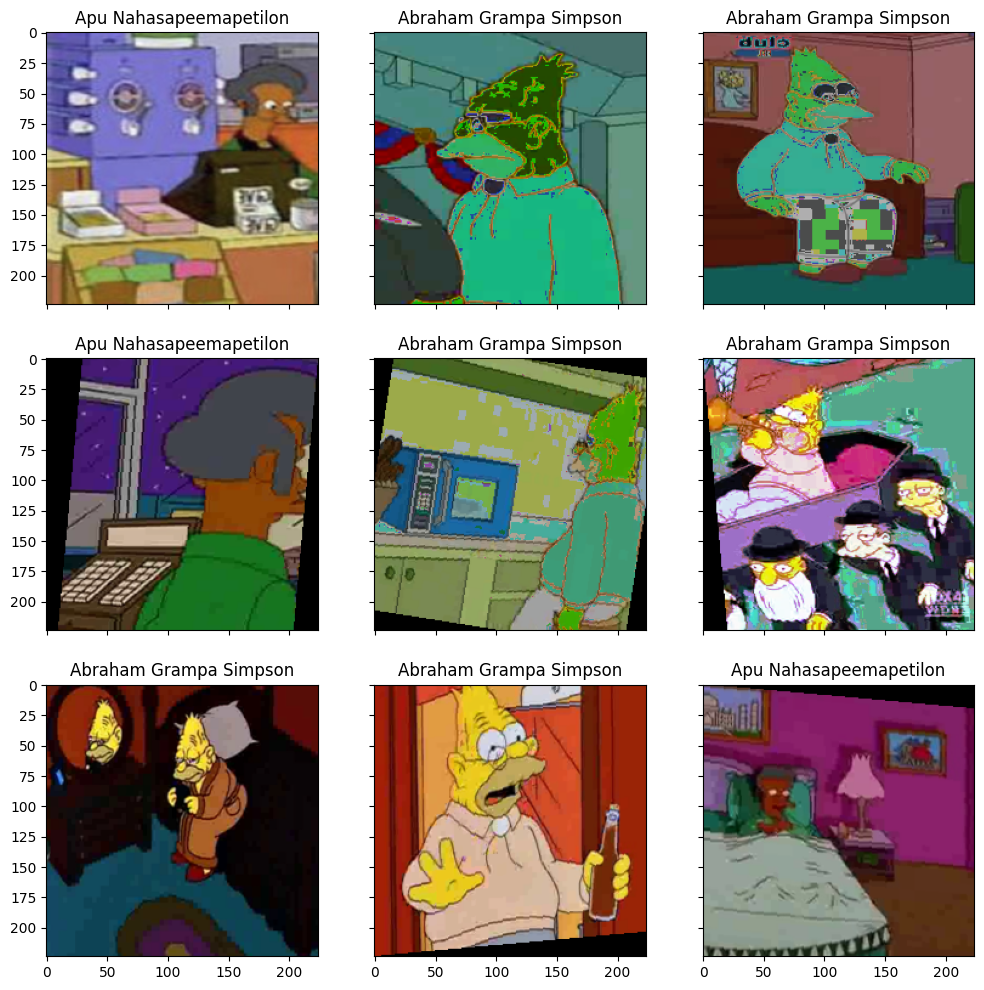

In [370]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.detach().cpu(), \
           title=img_label, plt_ax=fig_x)

### Inspect class imbalance

In [371]:
# characters = {}
# for i, (_, label) in enumerate(train_dataset):
#     img_label = ' '.join(map(lambda x: x.capitalize(), train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
#     if img_label not in characters:
#         characters[img_label] = 1
#     else:
#         characters[img_label] += 1

#     # if i > 1000:
#     #     break

# # characters

In [372]:
# fig, ax = plt.subplots()
# wedges, texts, autotexts = ax.pie(
#     list(characters.values()), 
#     autopct='%1.1f%%', 
#     pctdistance=1.17, 
#     textprops={'fontsize': 8, 'rotation_mode': 'anchor'} 
# )

# for wedge, autotext in zip(wedges, autotexts):
#     ang = (wedge.theta2 + wedge.theta1) / 2

#     if 90 < ang < 270:
#         ang -= 180

#     autotext.set_rotation(ang)
#     autotext.set_ha('center')
#     autotext.set_va('center')

# ax.set_title('classes')
# plt.show()

In [373]:
# total = sum(characters.values())

# characters_pct = copy.deepcopy(characters)
# for key in characters_pct:
#     characters_pct[key] = characters_pct[key] / total * 100

# pct = sorted(list(characters_pct.values()))
# # pct

In [374]:
# fig, ax = plt.subplots()
# ax.hist(
#     list(characters.values()), 
#     bins=25
# )

# ax.set_title('classes')
# plt.show()

#### Targeted synthetic augmentation for minority classes

### Построение нейросети

#### Функция обучения:

In [375]:
def fit_epoch(model, train_loader, optimizer, criterion, cutmix_or_mixup=None, scaler=None):
    """
    Функция обучает модель на одной эпохе, используя предоставленный dataloader.

    Эта функция проходит по всем данным в `train_loader`, выполняет шаг моделью (forward),
    вычисляет лосс, выполняет обратное распространение с помощью заданного
    оптимизатора и обновляет веса модели.
    В конце эпохи возвращаются средний лосс и
    точность на обучающем наборе данных.

    Параметры:
    ----------
    model : nn.Module
        Модель, которую необходимо обучить. Должна быть экземпляром класса
        PyTorch `nn.Module`.

    train_loader : DataLoader
        Загрузчик данных, который предоставляет батчи входных данных и
        соответствующих меток. Должен возвращать кортежи (inputs, labels).

    criterion : nn.Module
        Функция потерь, используемая для вычисления ошибки между
        предсказаниями модели и истинными метками.

    optimizer : torch.optim.Optimizer
        Оптимизатор, используемый для обновления весов модели на основе
        градиентов, вычисленных в процессе обучения.

    Функция возвращает:
    ----------
    tuple
        Кортеж, содержащий средний лосс (train_loss) и точность (train_acc)
        на обучающем наборе данных за текущую эпоху.
    """

    # print(f'[fit_epoch]: criterion: {criterion}')

    model.train()
    running_loss     = 0.0
    running_corrects = 0
    processed_data   = 0

    for inputs, labels in train_loader:
        if cutmix_or_mixup is not None:
            inputs, labels = cutmix_or_mixup(inputs, labels)

        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        with torch.amp.autocast(str(DEVICE)):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        targets = labels.argmax(1) if labels.ndim == 2 else labels
        preds   = outputs.argmax(1)
        running_corrects += (preds == targets).sum().item()
        
        running_loss += loss.item() * inputs.size(0)
        processed_data += inputs.size(0)

    print(f'[fit_epoch]: running_loss: {running_loss}')
    print(f'[fit_epoch]: processed_data: {processed_data}')

    train_loss = running_loss / processed_data
    train_acc = running_corrects / processed_data
    return train_loss, train_acc

#### Функция валидации:

In [376]:
def eval_epoch(model, val_loader, criterion):
    """
    Функция оценивает работу модели на валидационном наборе данных за одну эпоху.

    Эта функция проходит по всем данным в `val_loader`, выполняет прямое
    распространение, вычисляет лосс и точность модели. В конце эпохи
    возвращаются средний лосс и точность на валидационном наборе данных.

    Параметры:
    ----------
    model : nn.Module
        Модель, которую необходимо оценить. Должна быть экземпляром класса
        PyTorch `nn.Module`.

    val_loader : DataLoader
        Загрузчик данных, который предоставляет батчи входных данных и
        соответствующих меток для валидации. Должен возвращать кортежи
        (inputs, labels).

    criterion : nn.Module
        Функция потерь, используемая для вычисления ошибки между
        предсказаниями модели и истинными метками.

    Функция возвращает:
    ----------
    tuple
        Кортеж, содержащий среднюю потерю (val_loss) и точность (val_acc)
        на валидационном наборе данных за текущую эпоху.
    """
    
    # print(f'[eval_epoch]: criterion: {criterion}')

    model.eval()
    running_loss     = 0.0
    running_corrects = 0
    processed_size   = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            with torch.amp.autocast(str(DEVICE)):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            preds = outputs.argmax(1)

        running_corrects += (preds == labels).sum().item()
        running_loss += loss.item() * inputs.size(0)
        processed_size += inputs.size(0)

    print(f'[eval_epoch]: running_loss: {running_loss}')
    print(f'[eval_epoch]: processed_size: {processed_size}')

    val_loss = running_loss / processed_size
    val_acc = running_corrects / processed_size
    return val_loss, val_acc

#### Полный цикл обучения

In [377]:
def train(train_loader, val_loader, model, epochs, batch_size, opt, criterion=None, scheduler=None, early_stopping=None, cutmix_or_mixup=None, num_workers=0, scaler=None):
    """
    Функция обучает модель на обучающем наборе данных и оценивает ее на валидационном наборе данных.

    Эта функция создает загрузчики данных для обучающего и валидационного наборов,
    а затем выполняет обучение модели в течение заданного количества эпох.
    В конце каждой эпохи выводятся значения потерь и точности для обучающего и
    валидационного наборов. История обучения сохраняется и возвращается.

    Параметры:
    ----------
    train_loader : list
        Загрузчик, содержащий обучающие данные.

    val_loader : list
        Загрузчик, содержащий валидационные данные.

    model : nn.Module
        Модель, которую необходимо обучить. Должна быть экземпляром класса
        PyTorch `nn.Module`.

    epochs : int
        Количество эпох для обучения модели.

    batch_size : int
        Размер батча, используемый для загрузки данных.

    opt : torch.optim
        Метод оптимизации. Должен быть экземпляром класса
        PyTorch `torch.optim`.

    scheduler : torch.optim.lr_scheduler
        Стратегия изменения шага обучения во время обучения. Должна быть экземпляром класса
        PyTorch `torch.optim.lr_scheduler`.

    Возвращает:
    ----------
    list
        Список, содержащий кортежи (train_loss, train_acc, val_loss, val_acc)
        для каждой эпохи, где:
        - train_loss: средняя потеря на обучающем наборе.
        - train_acc: точность на обучающем наборе.
        - val_loss: средняя потеря на валидационном наборе.
        - val_acc: точность на валидационном наборе.
    """

    history = []
    log_template = "\nEpoch: {ep:03d}; train_loss: {t_loss:0.4f}; \
        val_loss: {v_loss:0.4f}; train_acc: {t_acc:0.4f}; val_acc: {v_acc:0.4f}"

    if criterion is None:
        criterion['train'] = nn.CrossEntropyLoss()
        criterion['val']   = nn.CrossEntropyLoss()

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, opt, criterion['train'], cutmix_or_mixup, scaler)
            val_loss, val_acc = eval_epoch(model, val_loader, criterion['val'])

            history.append((train_loss, train_acc, val_loss, val_acc))

            if scheduler is not None:
                scheduler.step()

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

            if early_stopping is not None:
                if early_stopping(val_loss):
                    print(f'Early stopping triggered')
                    break
        if early_stopping is not None:
            early_stopping.load_best_model(map_location=DEVICE)

    return history

#### Применение модели к данным

In [378]:
def predict(model, test_loader):
    """
    Функция выполняет предсказание классов для тестового набора данных с использованием обученной модели.

    Эта функция принимает модель и загрузчик тестовых данных, применяет модель к
    изображениям и возвращает вероятности предсказанных классов.

    Параметры:
    ----------
    model : nn.Module
        Обученная модель, которая будет использоваться для предсказания.
        Должна быть экземпляром класса PyTorch `nn.Module`.

    test_loader : DataLoader
        Загрузчик данных, который предоставляет батчи входных данных для тестирования.
        Должен возвращать тензоры входных данных.

    Возвращает:
    ----------
    numpy.ndarray
        Массив вероятностей предсказанных классов для каждого примера в тестовом наборе.
        Размерность массива будет (N, C), где N - количество примеров, а C - количество классов.
    """
    
    model.eval()
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

#### Early Stopping

In [379]:
class EarlyStopping():
    """
    Реализация стратегии ранней остановки, которая нацелена на минимизацию лоса.

    Параметры:
    ----------
    model : nn.Module
        Модель, с которой мы работаем (нужна для чекпоинтинга).

    patience : int
        Как долго мы будем ждать уменьшения ошибки, прежде чем обрывать обучение.

    min_delta : float
        Минимальное допустимое уменьшение ошибки, чтобы считаться значимым.

    verbose : bool
        Контроль принтов

    Методы:
    -------
    __call__(val_loss):
        Проверяет, что текущий лосс на валидиационной выборке лучше (меньше) чем раньше.
        Если данное условие не выполняется в течении n=patience эпох, то возвращает True.

    checkpoint():
        Сохраняет лучшую найденную версию модели.

    load_best_model():
        Загрузить лучшую найденную версию модели.
    """

    def __init__(self, model, patience, min_delta, verbose=True):
        self.model = model
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss) -> bool:
        val_loss = float(val_loss)
        if self.best_loss - val_loss > self.min_delta:
            if self.verbose:
                print(f'[EarlyStopping]: Validation loss decreased \
                    ({self.best_loss:.6f} -> {val_loss:.6f}). Saving model...')
            self.counter = 0
            self.best_loss = val_loss
            self.checkpoint()

            return False
        self.counter += 1

        if self.counter >= self.patience:
            if self.verbose:
                print(f'[EarlyStopping]: Reached plateau')
            return True
        
        return False
        
    def checkpoint(self):
        state = {
            'model': self.model.state_dict(),
            'val_loss': self.best_loss
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, f'./checkpoint/ckpt_{self.model.__class__.__name__}.pth')
    
    def load_best_model(self, map_location='cpu'):
        print(f'[EarlyStopping]: Loading best found model (with best_loss={self.best_loss})')
        ckpt = torch.load(f'./checkpoint/ckpt_{self.model.__class__.__name__}.pth',
                          map_location=map_location)
        self.model.load_state_dict(ckpt['model'])
        self.model.to(map_location)

        return ckpt

## EfficientNetV2‑S‑in21k

### load model

In [380]:
# load model
efficient_netv2 = timm.create_model('tf_efficientnetv2_s.in21k_ft_in1k',
                                    pretrained=True, drop_path_rate=0.2)

classifiers = {
    'plain': nn.Linear(in_features=efficient_netv2.classifier.in_features, 
                       out_features=N_CLASSES),
    'custom': nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(in_features=efficient_netv2.classifier.in_features, out_features=512),
        nn.SiLU(),
        nn.Linear(in_features=512, out_features=N_CLASSES)
    )
}

# replace classifier
efficient_netv2.classifier = classifiers['custom']

efficient_netv2 = efficient_netv2.to(DEVICE)

print(f"we will classify: {N_CLASSES} classes")
print(efficient_netv2)

we will classify: 42 classes
EfficientNet(
  (conv_stem): Conv2dSame(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path): Identity()
      )
      (1): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Id

### transfer learning

In [381]:
"""
Freeze strategy:
    Phase 1 (epochs 1-5)  - `requires_grad = False` for every layer except the classifier  
    Phase 2 (epochs 6-20) - unfreeze all layers; lower LR to 3e-4 globally
"""

cutmix = v2.CutMix(num_classes=N_CLASSES, alpha=0.1)
mixup  = v2.MixUp(num_classes=N_CLASSES, alpha=0.1)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

# parameters
n_epochs = {'phase1': 5, 'phase2': 15}
# n_epochs = {'phase1': 0, 'phase2': 1}
scaler = torch.amp.GradScaler(str(DEVICE))

# phase1 
optimizer = torch.optim.AdamW(efficient_netv2.classifier.parameters(), lr=3e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs['phase1'])
criterion = {
    'train': nn.CrossEntropyLoss(),
    'val':   nn.CrossEntropyLoss()
}

# freeze all layers except the classfier
for param in efficient_netv2.parameters(): param.requires_grad = False
for param in efficient_netv2.classifier.parameters(): param.requires_grad = True

history1 = train(train_loader, val_loader, efficient_netv2, n_epochs['phase1'], 
                 batch_size, optimizer, criterion, scheduler=scheduler, 
                 num_workers=num_workers, scaler=scaler)

print(f'{"-"*50}phase one done{"-"*50}')

# phase2 
# optimizer = torch.optim.AdamW([
#     {'params': efficient_netv2.blocks.parameters(),     'lr': 1e-5},
#     {'params': efficient_netv2.conv_head.parameters(),  'lr': 5e-5},
#     {'params': efficient_netv2.classifier.parameters(), 'lr': 3e-4}
# ], weight_decay=1e-4)
optimizer = torch.optim.AdamW(efficient_netv2.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs['phase2'])
early_stopping = EarlyStopping(efficient_netv2, patience=4, min_delta=1e-3)
criterion = {
    'train': SoftTargetCrossEntropy(),
    'val':   nn.CrossEntropyLoss()
}

# unfreeze all layers
for param in efficient_netv2.parameters(): param.requires_grad = True

history2 = train(train_loader, val_loader, efficient_netv2, n_epochs['phase2'], 
                 batch_size, optimizer, criterion, scheduler=scheduler, 
                 early_stopping=early_stopping, cutmix_or_mixup=cutmix_or_mixup, 
                 num_workers=num_workers, scaler=scaler)

print(f'{"-"*50}phase two done{"-"*50}')

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

[fit_epoch]: running_loss: 28291.15014743805
[fit_epoch]: processed_data: 15699


epoch:  20%|██        | 1/5 [02:50<11:21, 170.40s/it]

[eval_epoch]: running_loss: 5634.294095039368
[eval_epoch]: processed_size: 5234

Epoch: 001; train_loss: 1.8021;         val_loss: 1.0765; train_acc: 0.5216; val_acc: 0.7035
[fit_epoch]: running_loss: 22950.079024791718
[fit_epoch]: processed_data: 15699


epoch:  40%|████      | 2/5 [05:41<08:33, 171.09s/it]

[eval_epoch]: running_loss: 4780.004863023758
[eval_epoch]: processed_size: 5234

Epoch: 002; train_loss: 1.4619;         val_loss: 0.9133; train_acc: 0.6040; val_acc: 0.7533
[fit_epoch]: running_loss: 20902.59527039528
[fit_epoch]: processed_data: 15699


epoch:  60%|██████    | 3/5 [08:33<05:42, 171.29s/it]

[eval_epoch]: running_loss: 4411.275082111359
[eval_epoch]: processed_size: 5234

Epoch: 003; train_loss: 1.3315;         val_loss: 0.8428; train_acc: 0.6414; val_acc: 0.7757
[fit_epoch]: running_loss: 18869.54862678051
[fit_epoch]: processed_data: 15699


epoch:  80%|████████  | 4/5 [11:25<02:51, 171.66s/it]

[eval_epoch]: running_loss: 4139.92406129837
[eval_epoch]: processed_size: 5234

Epoch: 004; train_loss: 1.2020;         val_loss: 0.7910; train_acc: 0.6697; val_acc: 0.7843
[fit_epoch]: running_loss: 17680.131370663643
[fit_epoch]: processed_data: 15699


epoch: 100%|██████████| 5/5 [14:17<00:00, 171.41s/it]


[eval_epoch]: running_loss: 3999.953192472458
[eval_epoch]: processed_size: 5234

Epoch: 005; train_loss: 1.1262;         val_loss: 0.7642; train_acc: 0.6865; val_acc: 0.7917
--------------------------------------------------phase one done--------------------------------------------------


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

[fit_epoch]: running_loss: 19403.00180181861
[fit_epoch]: processed_data: 15699


epoch:   7%|▋         | 1/15 [07:02<1:38:41, 422.96s/it]

[eval_epoch]: running_loss: 972.6185547709465
[eval_epoch]: processed_size: 5234

Epoch: 001; train_loss: 1.2359;         val_loss: 0.1858; train_acc: 0.7715; val_acc: 0.9570
[EarlyStopping]: Validation loss decreased                     (inf -> 0.185827). Saving model...
[fit_epoch]: running_loss: 14747.539971768856
[fit_epoch]: processed_data: 15699


epoch:  13%|█▎        | 2/15 [14:06<1:31:42, 423.28s/it]

[eval_epoch]: running_loss: 850.8011769354343
[eval_epoch]: processed_size: 5234

Epoch: 002; train_loss: 0.9394;         val_loss: 0.1626; train_acc: 0.8457; val_acc: 0.9727
[EarlyStopping]: Validation loss decreased                     (0.185827 -> 0.162553). Saving model...
[fit_epoch]: running_loss: 13759.288787811995
[fit_epoch]: processed_data: 15699


epoch:  20%|██        | 3/15 [21:10<1:24:42, 423.53s/it]

[eval_epoch]: running_loss: 1061.279258131981
[eval_epoch]: processed_size: 5234

Epoch: 003; train_loss: 0.8764;         val_loss: 0.2028; train_acc: 0.8615; val_acc: 0.9721
[fit_epoch]: running_loss: 12586.878440499306
[fit_epoch]: processed_data: 15699


epoch:  27%|██▋       | 4/15 [28:13<1:17:37, 423.45s/it]

[eval_epoch]: running_loss: 771.6445925831795
[eval_epoch]: processed_size: 5234

Epoch: 004; train_loss: 0.8018;         val_loss: 0.1474; train_acc: 0.8754; val_acc: 0.9769
[EarlyStopping]: Validation loss decreased                     (0.162553 -> 0.147429). Saving model...
[fit_epoch]: running_loss: 11554.510531038046
[fit_epoch]: processed_data: 15699


epoch:  33%|███▎      | 5/15 [35:16<1:10:34, 423.41s/it]

[eval_epoch]: running_loss: 628.2898942232132
[eval_epoch]: processed_size: 5234

Epoch: 005; train_loss: 0.7360;         val_loss: 0.1200; train_acc: 0.8909; val_acc: 0.9803
[EarlyStopping]: Validation loss decreased                     (0.147429 -> 0.120040). Saving model...
[fit_epoch]: running_loss: 10356.289826728404
[fit_epoch]: processed_data: 15699


epoch:  40%|████      | 6/15 [42:20<1:03:31, 423.53s/it]

[eval_epoch]: running_loss: 600.3442888259888
[eval_epoch]: processed_size: 5234

Epoch: 006; train_loss: 0.6597;         val_loss: 0.1147; train_acc: 0.8991; val_acc: 0.9797
[EarlyStopping]: Validation loss decreased                     (0.120040 -> 0.114701). Saving model...
[fit_epoch]: running_loss: 10124.466319948435
[fit_epoch]: processed_data: 15699


epoch:  47%|████▋     | 7/15 [49:23<56:27, 423.44s/it]  

[eval_epoch]: running_loss: 623.7394919395447
[eval_epoch]: processed_size: 5234

Epoch: 007; train_loss: 0.6449;         val_loss: 0.1192; train_acc: 0.8999; val_acc: 0.9813
[fit_epoch]: running_loss: 10292.405111983418
[fit_epoch]: processed_data: 15699


epoch:  53%|█████▎    | 8/15 [56:27<49:24, 423.49s/it]

[eval_epoch]: running_loss: 574.8468495607376
[eval_epoch]: processed_size: 5234

Epoch: 008; train_loss: 0.6556;         val_loss: 0.1098; train_acc: 0.9045; val_acc: 0.9847
[EarlyStopping]: Validation loss decreased                     (0.114701 -> 0.109829). Saving model...
[fit_epoch]: running_loss: 9885.54410648346
[fit_epoch]: processed_data: 15699


epoch:  60%|██████    | 9/15 [1:03:32<42:23, 423.85s/it]

[eval_epoch]: running_loss: 621.4460346698761
[eval_epoch]: processed_size: 5234

Epoch: 009; train_loss: 0.6297;         val_loss: 0.1187; train_acc: 0.9026; val_acc: 0.9864
[fit_epoch]: running_loss: 9208.268849171698
[fit_epoch]: processed_data: 15699


epoch:  67%|██████▋   | 10/15 [1:10:36<35:19, 423.95s/it]

[eval_epoch]: running_loss: 464.04730874300003
[eval_epoch]: processed_size: 5234

Epoch: 010; train_loss: 0.5866;         val_loss: 0.0887; train_acc: 0.9114; val_acc: 0.9866
[EarlyStopping]: Validation loss decreased                     (0.109829 -> 0.088660). Saving model...
[fit_epoch]: running_loss: 9372.566900229082
[fit_epoch]: processed_data: 15699


epoch:  73%|███████▎  | 11/15 [1:17:40<28:16, 424.02s/it]

[eval_epoch]: running_loss: 450.884718477726
[eval_epoch]: processed_size: 5234

Epoch: 011; train_loss: 0.5970;         val_loss: 0.0861; train_acc: 0.9038; val_acc: 0.9872
[EarlyStopping]: Validation loss decreased                     (0.088660 -> 0.086145). Saving model...
[fit_epoch]: running_loss: 8851.927043430507
[fit_epoch]: processed_data: 15699


epoch:  80%|████████  | 12/15 [1:24:44<21:11, 423.95s/it]

[eval_epoch]: running_loss: 441.0731978416443
[eval_epoch]: processed_size: 5234

Epoch: 012; train_loss: 0.5639;         val_loss: 0.0843; train_acc: 0.9080; val_acc: 0.9872
[EarlyStopping]: Validation loss decreased                     (0.086145 -> 0.084271). Saving model...
[fit_epoch]: running_loss: 8113.4382223933935
[fit_epoch]: processed_data: 15699


epoch:  87%|████████▋ | 13/15 [1:31:48<14:07, 423.87s/it]

[eval_epoch]: running_loss: 393.30590254068375
[eval_epoch]: processed_size: 5234

Epoch: 013; train_loss: 0.5168;         val_loss: 0.0751; train_acc: 0.9215; val_acc: 0.9887
[EarlyStopping]: Validation loss decreased                     (0.084271 -> 0.075144). Saving model...
[fit_epoch]: running_loss: 9229.175854057074
[fit_epoch]: processed_data: 15699


epoch:  93%|█████████▎| 14/15 [1:38:57<07:05, 425.53s/it]

[eval_epoch]: running_loss: 457.04469561576843
[eval_epoch]: processed_size: 5234

Epoch: 014; train_loss: 0.5879;         val_loss: 0.0873; train_acc: 0.9024; val_acc: 0.9883
[fit_epoch]: running_loss: 8169.387702640146
[fit_epoch]: processed_data: 15699


epoch: 100%|██████████| 15/15 [1:46:03<00:00, 425.71s/it]

[eval_epoch]: running_loss: 504.91467452049255
[eval_epoch]: processed_size: 5234

Epoch: 015; train_loss: 0.5204;         val_loss: 0.0965; train_acc: 0.9220; val_acc: 0.9882
[EarlyStopping]: Loading best found model (with best_loss=0.07514442157827354)


epoch: 100%|██████████| 15/15 [1:46:03<00:00, 424.25s/it]

--------------------------------------------------phase two done--------------------------------------------------


In [382]:
history = history1 + history2
# history

Построим кривые обучения

In [383]:
loss, acc, val_loss, val_acc = zip(*history)

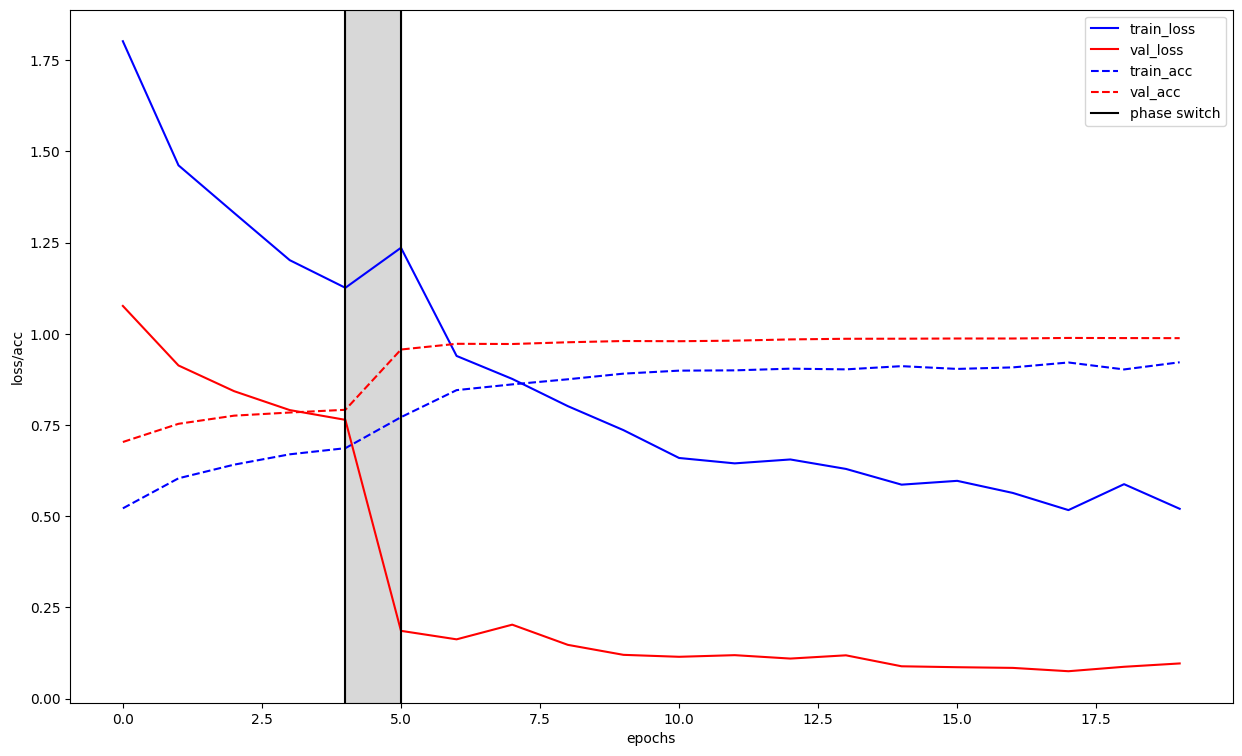

In [384]:
plt.figure(figsize=(15, 9))

# loss 
plt.plot(loss, label="train_loss", color='b')
plt.plot(val_loss, label="val_loss", color='r')

# acc
plt.plot(acc, label="train_acc", linestyle='--', color='b')
plt.plot(val_acc, label="val_acc", linestyle='--', color='r')

# phase switch
# plt.axvline(len(history1)-1/2, label='phase switch', color='black')
plt.axvline(len(history1)-1, color='black')
plt.axvline(len(history1), label='phase switch', color='black')
plt.axvspan(len(history1)-1, len(history1), color='gray', alpha=0.3)

plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss/acc")
plt.show()

In [385]:
model = efficient_netv2
model = model.to(DEVICE)
model.eval()

EfficientNet(
  (conv_stem): Conv2dSame(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path): Identity()
      )
      (1): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path):

### Sneak-Peak

In [386]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

#### Single predict

In [387]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

# # random_characters = int(np.random.uniform(0,1000))
# # ex_img, true_label = val_dataset[random_characters]
# # probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

#### Random predict

In [388]:
# idxs = list(map(int, np.random.uniform(0,1000, 20)))
# imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

# actual_labels = [val_dataset[id][1] for id in idxs]

# probs_ims = predict(model, imgs)
# y_pred = np.argmax(probs_ims,-1)
# # preds_class = [label_encoder.classes_[i] for i in y_pred]

# f1 = f1_score(actual_labels, y_pred, average='micro')

# print("F1-оценка:", f1)

#### F1 scores

In [389]:
# val_files  = []
# val_labels = []
# for inputs, labels in val_loader: 
#     val_files.append(inputs)
#     val_labels.append(labels)
# val_files  = torch.cat(val_files, dim=0)
# val_labels = torch.cat(val_labels, dim=0)

# val_files_loader = DataLoader(val_files, batch_size=batch_size, shuffle=False)

# with torch.no_grad(), torch.amp.autocast(str(DEVICE)):
#     probs  = predict(model, val_files_loader)
#     y_pred = np.argmax(probs,-1)

# f1 = f1_score(val_labels, y_pred, average='micro')
# print("F1-оценка:", f1)

In [390]:
labels_true, labels_prob = [], []
with torch.no_grad(), torch.amp.autocast(str(DEVICE)):
    for inputs, labels in train_loader: 
        inputs = inputs.to(DEVICE, non_blocking=True)

        logits  = model(inputs)
        labels_true.append(labels.cpu().numpy()) 
        labels_prob.append(logits.softmax(1).cpu().numpy())

labels_true = np.concatenate(labels_true)
labels_prob = np.concatenate(labels_prob)

labels_pred = labels_prob.argmax(1)

f1 = f1_score(labels_true, labels_pred, average='micro')
print("F1-оценка:", f1)

F1-оценка: 0.9985349385311166


In [391]:
labels_true, labels_prob = [], []
with torch.no_grad(), torch.amp.autocast(str(DEVICE)):
    for inputs, labels in val_loader: 
        inputs = inputs.to(DEVICE, non_blocking=True)

        logits  = model(inputs)
        labels_true.append(labels.cpu().numpy()) 
        labels_prob.append(logits.softmax(1).cpu().numpy())

labels_true = np.concatenate(labels_true)
labels_prob = np.concatenate(labels_prob)

labels_pred = labels_prob.argmax(1)

f1 = f1_score(labels_true, labels_pred, average='micro')
print("F1-оценка:", f1)

F1-оценка: 0.9887275506304929


```python
(phase1: 1 epoch; phase2: 1 epoch; classfier: plain): {
    train: 0.9759857315752596
    val:   0.9631257164692396
}

(phase1: 2 epoch; phase2: 2 epoch; classfier: plain): {
    train: 0.9748391617300465
    val:   0.9648452426442491
}

(phase1: 0 epoch; phase2: 1 epoch; classfier: plain): {
    train: 0.9706350722975986
    val:   0.9627435995414597
}

(phase1: 5 epoch; phase2: 15 epoch; classfier: plain): {
    train: 0.9993630167526594
    val:   0.9875811998471532
}

(phase1: 5 epoch; phase2: 15 epoch; classfier: custom): {
    train: 0.9985349385311166
    val:   0.9887275506304929
}

(phase1: 1 epoch; phase2: 1 epoch; classfier: custom): {
    train: 0.958277597299191
    val:   0.9484142147497134
}

RandAugment -> TrivialAugmentWide
added label_smoothing=0.1 to all CrossEntropyLoss
changed optimizer in phase2
(phase1: 1 epoch; phase2: 1 epoch; classfier: plain): {
    train: 0.8376966685776164
    val:   0.8614826136797861
}
```

Сделаем визуализацию, чтобы посмотреть насколько сеть уверена в своих ответах.

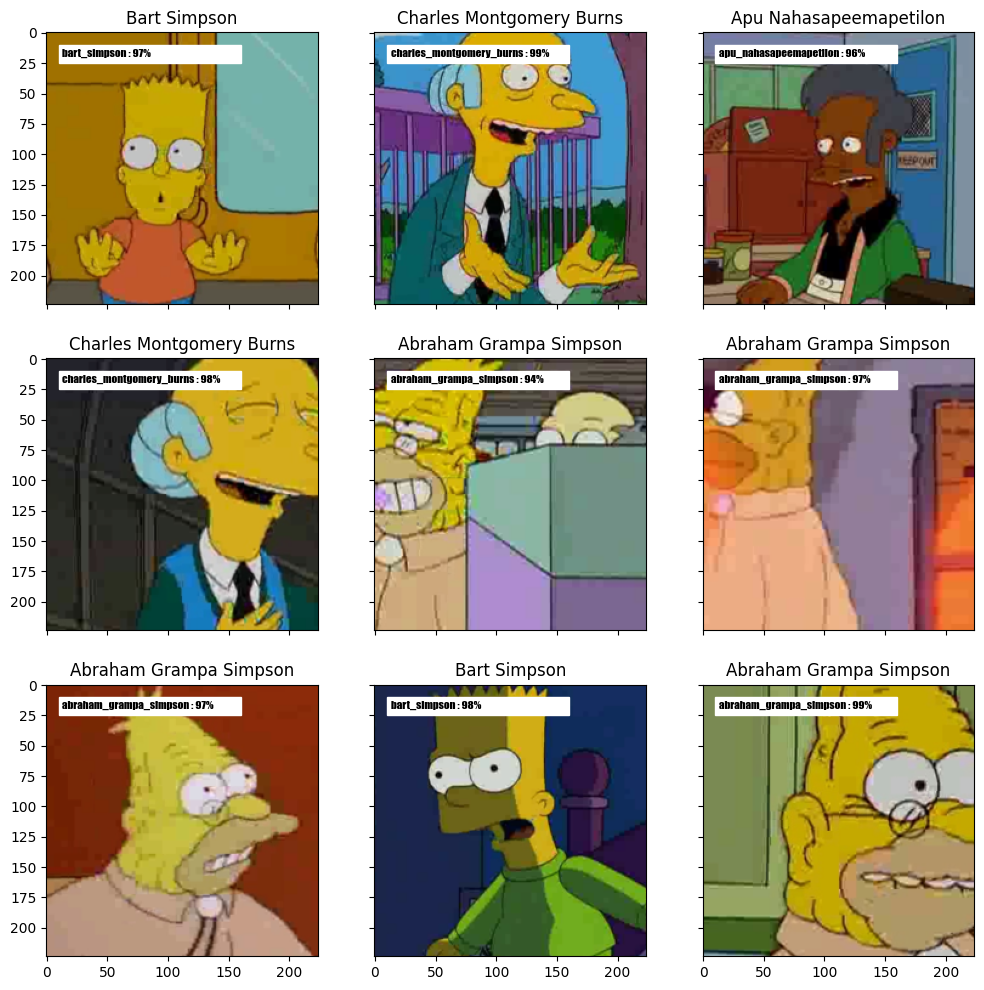

In [392]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                label_encoder.inverse_transform([label])[0].split('_')))

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((10, 10),150,15,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(13, 13, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

#### Display incorrectly predicted images

In [ ]:
import random, matplotlib.pyplot as plt, matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

mis_imgs, mis_true, mis_pred, mis_conf = [], [], [], []

with torch.no_grad(), torch.amp.autocast(str(DEVICE)):
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE, non_blocking=True)
        logits = model(inputs)
        probs  = logits.softmax(1).cpu() # [B, C]
        preds  = probs.argmax(1)         # [B]

        for img, y_true, y_pred, prob in zip(inputs.cpu(), labels, preds, probs):
            if y_true != y_pred: # keep the errors only
                mis_imgs.append(img)
                mis_true.append(y_true.item())
                mis_pred.append(y_pred.item())
                mis_conf.append(prob[y_pred].item())

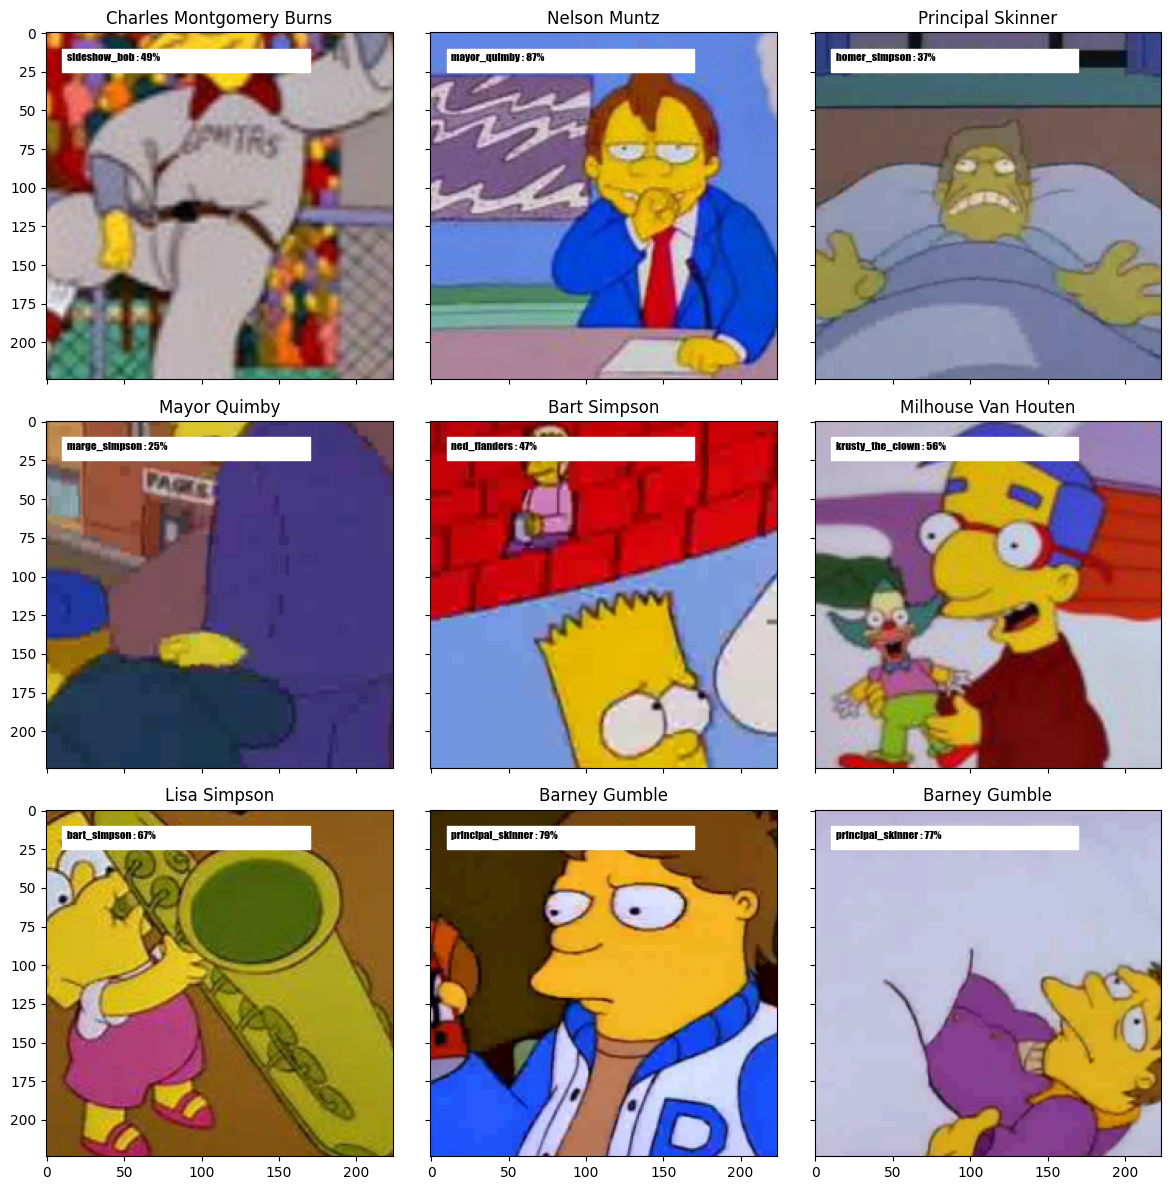

In [ ]:
if len(mis_imgs) == 0:
    print("no errors on the validation set")
else:
    sel = random.sample(range(len(mis_imgs)), k=min(9, len(mis_imgs)))

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12),
                             sharex=True, sharey=True)
    axes = axes.flatten()

    font0 = FontProperties(); font0.set_family("fantasy")

    for ax_idx, mis_idx in enumerate(sel):
        ax = axes[ax_idx]

        img       = mis_imgs[mis_idx]
        y_true    = mis_true[mis_idx]
        y_pred    = mis_pred[mis_idx]
        conf_pred = mis_conf[mis_idx] * 100

        # labels
        true_lbl = " ".join(w.capitalize()
                            for w in label_encoder.inverse_transform([y_true])[0].split('_'))
        pred_lbl = label_encoder.classes_[y_pred]

        imshow(img, title=true_lbl, plt_ax=ax)         

        # white background for overlay text
        ax.add_patch(patches.Rectangle((10, 10), 160, 15, color='white'))

        # predicted label + confidence
        ax.text(13, 13, f"{pred_lbl} : {conf_pred:.0f}%",
                horizontalalignment='left',
                verticalalignment='top',
                fontsize=8,
                fontproperties=font0,
                fontweight='bold',
                color='black')

    # hide any unused sub‑plots (when < 9 errors)
    for ax in axes[len(sel):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


#### Display probabilities of a brand new image

In [ ]:
from PIL import Image
from torchvision import transforms
import torch
import numpy as np

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(RESCALE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

def predict_topk(model, img_path, transform=preprocess, k=5, device=DEVICE):
    """
    Args
    ----
    model     : torch.nn.Module (already on DEVICE)
    img_path  : str | pathlib.Path | file-like object
    transform : torchvision transform identical to validation
    k         : number of highest-probability classes to return
    device    : torch.device ('cuda', 'mps', 'cpu', ...)
    """
    img = Image.open(img_path).convert('RGB')
    tensor = transform(img).unsqueeze(0).to(device, non_blocking=True)

    with torch.no_grad(), torch.amp.autocast(str(device)):
        logits = model(tensor)
        probs  = logits.softmax(1)                

    top_p, top_i = probs.topk(k, dim=1)            
    top_p = top_p.squeeze(0).cpu().numpy()      
    top_i = top_i.squeeze(0).cpu().numpy()     

    top_labels = label_encoder.inverse_transform(top_i)

    print(f"Top‑{k} predictions for {img_path}:")
    for rank, (lbl, p) in enumerate(zip(top_labels, top_p), 1):
        print(f"{rank:>2}. {lbl:<25} {p*100:5.2f}%")

    return list(zip(top_labels, top_p))


# Example usage 
result = predict_topk(model, "./extra/lisa.jpg")
result

Top‑5 predictions for ./extra/lisa.jpg:
 1. lisa_simpson              99.20%
 2. marge_simpson              0.25%
 3. krusty_the_clown           0.15%
 4. homer_simpson              0.06%
 5. moe_szyslak                0.04%


[(np.str_('lisa_simpson'), np.float32(0.99196)),
 (np.str_('marge_simpson'), np.float32(0.0025120673)),
 (np.str_('krusty_the_clown'), np.float32(0.0015177984)),
 (np.str_('homer_simpson'), np.float32(0.00064519164)),
 (np.str_('moe_szyslak'), np.float32(0.00044256813))]

#### Display probabilities of a brand new image with an image

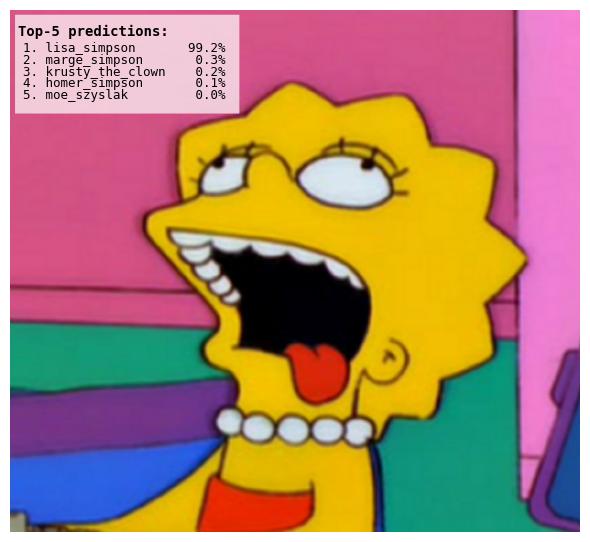

In [ ]:
import torch, numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(RESCALE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

def show_image_with_topk(model, img_path, transform=preprocess, k=5,
                         device=DEVICE, font_family="monospace"):
    """
    Loads an image, runs inference, and overlays Top-k probs.

    Args
    ----
    model     : trained nn.Module (already set to .eval() and on DEVICE)
    img_path  : str | Path | file-like
    transform : torchvision transform identical to val/test
    k         : number of top classes to show (default 5)
    device    : torch.device ('cuda', 'mps', 'cpu', ...)
    """

    pil_img   = Image.open(img_path).convert("RGB")
    tensor_in = transform(pil_img).unsqueeze(0).to(device, non_blocking=True)

    with torch.no_grad(), torch.amp.autocast(str(device)):
        logits = model(tensor_in)
        probs  = logits.softmax(1)              

    top_p, top_i = probs.topk(k, dim=1)
    top_p, top_i = top_p[0].cpu().numpy(), top_i[0].cpu().numpy()
    top_labels   = label_encoder.inverse_transform(top_i)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(pil_img)
    ax.axis("off")

    pad, height = 5, 14 * (k + 1) + 17 
    ax.add_patch(
        patches.FancyBboxPatch(
            (pad, pad), 230, height,
            boxstyle="round,pad=0.3",
            linewidth=0,
            facecolor="white",
            alpha=0.7
        )
    )

    font = FontProperties()
    font.set_family(font_family)
    ax.text(pad + 3, pad + 10, "Top-{} predictions:".format(k),
            fontsize=10, fontproperties=font, fontweight="bold",
            verticalalignment="top", color="black")

    for idx, (lbl, p) in enumerate(zip(top_labels, top_p), start=1):
        ax.text(pad + 8, pad + 12 + 12 * idx + 14,
                f"{idx}. {lbl:<17} {p*100:5.1f}%",
                fontsize=9, fontproperties=font, color="black")

    plt.tight_layout()
    plt.show()

    return list(zip(top_labels, top_p))

preds = show_image_with_topk(model, "./extra/lisa.jpg", k=5)


### Submit на Kaggle

In [393]:
test_dataset = SimpsonsDataset(test_files, mode="test", label_encoder=label_encoder)
test_loader  = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
probs = predict(model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [394]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
# my_submit.to_csv('submission_phase2_1_epoch_.csv', index=False)
# my_submit.to_csv('submission_phase1_1_epoch_phase2_1_epoch_.csv', index=False)
# my_submit.to_csv('submission_phase1_5_epoch_phase2_15_epoch_plain.csv', index=False)
# my_submit.to_csv('submission_phase1_5_epoch_phase2_15_epoch_custom.csv', index=False)